In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Display the first few rows of the dataset and the data types of each column
print(data.head())
print(data.dtypes)


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.454506  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.465666  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.362820  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.351058  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.393281  447610800
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


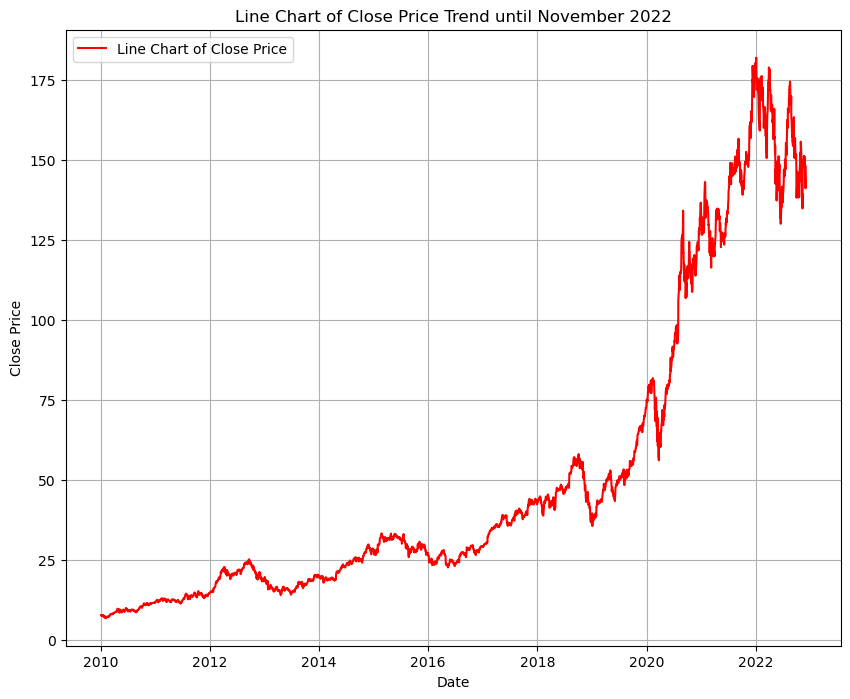

In [2]:
# Filter the data to show from start till "30-11-22"
filtered_data = data[:'2022-11-30']

# Plotting the filtered data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Close'], label='Line Chart of Close Price', color='red')
plt.title('Line Chart of Close Price Trend until November 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# LSTM Model

In [3]:
# Scaling the data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the training and validation data for LSTM
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Include the last 60 days of training data for context

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to be suitable for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Predicting 1 value

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test))


C:\Users\BAHU Computers\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0056 - val_loss: 0.0014
Epoch 2/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 8.8000e-05 - val_loss: 0.0016
Epoch 3/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 1.0109e-04 - val_loss: 0.0027
Epoch 4/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 8.5785e-05 - val_loss: 0.0017
Epoch 5/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 6.4930e-05 - val_loss: 0.0014
Epoch 6/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 6.4623e-05 - val_loss: 0.0017
Epoch 7/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 5.8744e-05 - val_loss: 0.0011
Epoch 8/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.4261e-05 - val_loss: 0.0029
Epoch 9/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 6.2298e-05 - val_loss: 0.0018
Epoch 10/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.5668e-05 - val_loss: 0.0032
Epoch 11/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.3828e-05 - val_loss: 0.0015
Epoch 12/80
80/80 ━━━━━

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


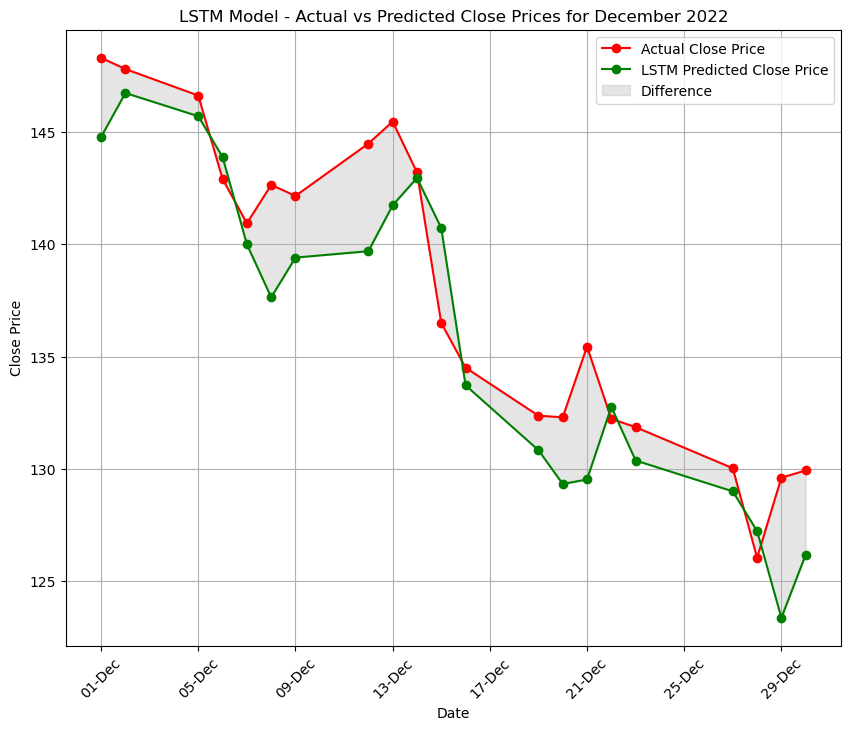

In [6]:
# Make predictions on the test data
predicted_scaled = model.predict(X_test)

# Inverse transform to get the actual values
predicted = scaler.inverse_transform(predicted_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Filter the data for December 2022 only
december_start = '2022-12-01'
december_end = '2022-12-30'
december_mask = (data.index >= december_start) & (data.index <= december_end)

# Filter the actual and predicted values for December 2022
december_dates = data.index[december_mask]
predicted_december = predicted[-len(december_dates):]
y_test_december = y_test_actual[-len(december_dates):]

# Plotting the LSTM predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(december_dates, y_test_december, label='Actual Close Price', color='red', marker='o')
plt.plot(december_dates, predicted_december, label='LSTM Predicted Close Price', color='green', marker='o')
plt.title('LSTM Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(december_dates, y_test_december.flatten(), predicted_december.flatten(), 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()